In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import sys
sys.path.insert(0,'../src')
from dummy_popnet import DummyNetwork

In [4]:
config = {
    "size_first_gen" : 50,
    "child_probabilities" : {
        0 : [0.05,0.1,0.2,0.45,0.2],
        1 : [0.05,0.2,0.3,0.4,0.05],
        2 : [0.05,0.3,0.4,0.2,0.05] 
    },
    "death_probability" : {
        0: 1,
        1: 0.1,
        2: 0.01,
        3: 0
    },
    "marriage_probabilities" : {
        0: 1,
        1: 0.9,
        2: 0.8,
        3: 0
    },
    "neighbor_threshold" : 0.05,
    "number_of_schools" : 3,
    "number_of_workplaces" : 7
}

In [5]:
d = DummyNetwork(**config)

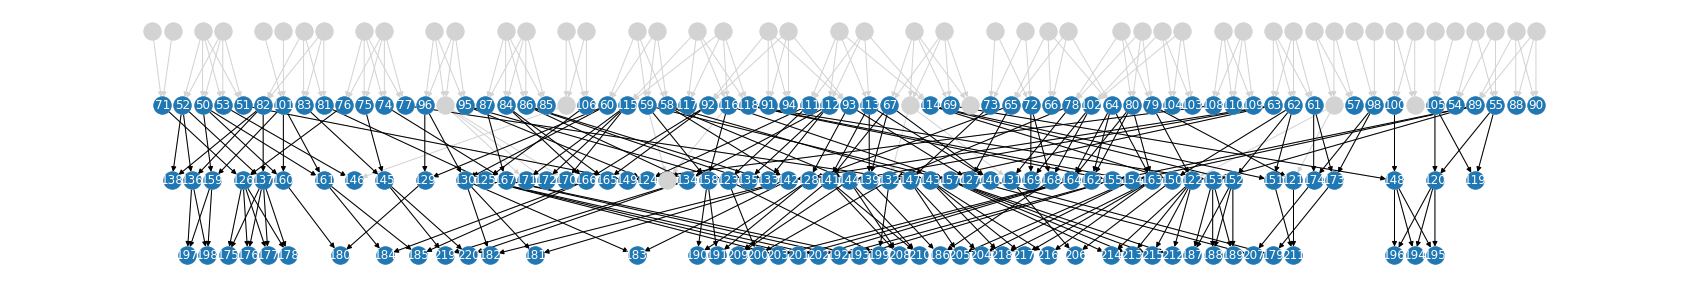

In [6]:
d.draw_family_tree()

In [7]:
n,e = d.export_network()

In [8]:
n.to_csv('../test_data/dummy_popnet/popnet_nodelist.csv',index=False,header=True)
e.to_csv('../test_data/dummy_popnet/popnet_edgelist.csv',index=False,header=True)

## Creating larger dummy network to develop test database

In [1]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from random import sample, choice
import string
import pandas as pd

In [4]:
import sys
sys.path.insert(0,'../src')
from dummy_popnet import DummyNetwork

In [5]:
config = {
    "size_first_gen" : 500,
    "child_probabilities" : {
        0 : [0.05,0.1,0.2,0.45,0.2],
        1 : [0.05,0.2,0.3,0.4,0.05],
        2 : [0.05,0.3,0.4,0.2,0.05] 
    },
    "death_probability" : {
        0: 1,
        1: 0.1,
        2: 0.01,
        3: 0
    },
    "marriage_probabilities" : {
        0: 1,
        1: 0.9,
        2: 0.8,
        3: 0
    },
    "neighbor_threshold" : 0.02,
    "number_of_schools" : 30,
    "number_of_workplaces" : 70
}

In [ ]:
# nodes and edges
d = DummyNetwork(**config)

In [106]:
n,e = d.export_network()
e.rename({"source":"label_source","target":"label_target"},axis=1,inplace=True)
# d.draw_family_tree()

#### Encoding the edges

In [107]:
link_coding = {
    "household":202,
    "child":107,
    "grandchild":108,
    "aunt / uncle":101,
    "school":501,
    "work":401,
    "partner":201,
    "sister / brother-in-law": 119,
    "cousin":105,
    "neighbor":301,
    "niece / nephew":106,
    "grandparent":110,
    "mother / father-in-law": 116,
    "sibling":113,
    "parent":104,
    "daughter / son-in-law": 117
}

In [108]:
e["edge_type"] = e["edgetype"].map(link_coding)
e.drop("edgetype",axis=1,inplace=True)
e.head()

,label_source,label_target,edge_type
0,1535,687,106
1,691,2328,110
2,1594,1284,401
3,2390,1984,501
4,1708,1778,401


#### Attributes

##### Age, gender, migrant generation

In [109]:
n["gender"] +=1

def create_age(gen):
    a = np.random.randint((3-gen)*20,(4-gen)*20)
    return a

n["age"] = n["generation"].map(create_age)

n["migrant_generation"]=0

migrants = sample(n["node_id"].tolist(),6)

n["migrant_generation"][n["node_id"].isin(migrants[0:3])]=1
n["migrant_generation"][n["node_id"].isin(migrants[3:6])]=2
n["migrant_generation"].value_counts()

0    1826
1       3
2       3
Name: migrant_generation, dtype: int64

##### Spatial

In [110]:
n["x"] = n["node_id"].map(lambda x: d.household_coords[d.household_dict[x],0])
n["y"] = n["node_id"].map(lambda x: d.household_coords[d.household_dict[x],1])

In [111]:
km_clusterer = KMeans(3)
n["gemeente_labels"] = km_clusterer.fit_predict(n[["x","y"]])
n["wijk_labels"] = None
n["buurt_labels"] = None
for i in n["gemeente_labels"].unique():
    n["wijk_labels"][n["gemeente_labels"]==i] = km_clusterer.fit_predict(n[["x","y"]][n["gemeente_labels"]==i])

for g,w in n[["gemeente_labels","wijk_labels"]].value_counts().index.tolist():
    mask = (n["gemeente_labels"]==g)&(n["wijk_labels"]==w)
    n["buurt_labels"][mask] = km_clusterer.fit_predict(n[["x","y"]][mask])   

/tmp/ipykernel_123536/2357331738.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n["wijk_labels"][n["gemeente_labels"]==i] = km_clusterer.fit_predict(n[["x","y"]][n["gemeente_labels"]==i])
/tmp/ipykernel_123536/2357331738.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n["wijk_labels"][n["gemeente_labels"]==i] = km_clusterer.fit_predict(n[["x","y"]][n["gemeente_labels"]==i])
/tmp/ipykernel_123536/2357331738.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [112]:
urb_level_buurt = {}
for c in range(27):
    urb_level_buurt[c] = np.random.randint(1,6)
urb_level_gemeente = {0:1,1:4,2:5}
name_gemeente = {0:"Monnickendam",1:"Dordrecht",2:"Amsterdam"}

In [113]:
n["urbanization_gemeente"] = None
n["urbanization_buurt"] = None
n["gemeente_name"] = None

for g in range(3):
    for w in range(3):
        for b in range(3):
            c = g*9+w*3+b
            mask = (n["gemeente_labels"]==g)&(n["wijk_labels"]==w)&(n["buurt_labels"]==b)
            n["urbanization_gemeente"][n["gemeente_labels"]==g] = urb_level_gemeente[g]
            n["gemeente_name"][n["gemeente_labels"]==g] = name_gemeente[g]
            n["urbanization_buurt"] = urb_level_buurt[c]

/tmp/ipykernel_123536/1191199368.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n["urbanization_gemeente"][n["gemeente_labels"]==g] = urb_level_gemeente[g]
/tmp/ipykernel_123536/1191199368.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n["gemeente_name"][n["gemeente_labels"]==g] = name_gemeente[g]


In [114]:
n["province"] = n["gemeente_labels"]+28
n["countrypart"] = n["gemeente_labels"]+1

In [115]:
n["gemeente_code"] = "GM" + n["gemeente_labels"].map(str).str.zfill(4)
n["wijk_code"] = "WK" + n["gemeente_labels"].map(str).str.zfill(4) + n["wijk_labels"].map(str).str.zfill(2)
n["location_code"] = (n["gemeente_labels"].map(str).str.zfill(4) + n["wijk_labels"].map(str).str.zfill(2) + n["buurt_labels"].map(str).str.zfill(2)).map(int)
n["buurt_code"] = "BU" + n["gemeente_labels"].map(str).str.zfill(4) + n["wijk_labels"].map(str).str.zfill(2) + n["buurt_labels"].map(str).str.zfill(2)

In [116]:
for level in ["buurt","wijk","gemeente"]:
    n[level+"_x"] = n[level+"_code"].map(n.groupby([level+"_code"])["x"].mean().T.to_dict())
    n[level+"_lon"] = n[level+"_code"].map(n.groupby([level+"_code"])["x"].mean().T.to_dict())
    n[level+"_y"] = n[level+"_code"].map(n.groupby([level+"_code"])["y"].mean().T.to_dict())
    n[level+"_lat"] = n[level+"_code"].map(n.groupby([level+"_code"])["y"].mean().T.to_dict())

In [117]:
n.head()

,node_id,generation,gender,age,migrant_generation,x,y,gemeente_labels,wijk_labels,buurt_labels,...,buurt_y,buurt_lat,wijk_x,wijk_lon,wijk_y,wijk_lat,gemeente_x,gemeente_lon,gemeente_y,gemeente_lat
0,500,1,2,43,0,0.263447,0.886477,0,0,0,...,0.881515,0.881515,0.131804,0.131804,0.836203,0.836203,0.307591,0.307591,0.735024,0.735024
1,502,1,1,58,0,0.437864,0.761098,0,1,1,...,0.703447,0.703447,0.511843,0.511843,0.814864,0.814864,0.307591,0.307591,0.735024,0.735024
2,503,1,2,49,0,0.177321,0.487733,0,2,0,...,0.572627,0.572627,0.250976,0.250976,0.576131,0.576131,0.307591,0.307591,0.735024,0.735024
3,504,1,2,41,0,0.028716,0.024930,2,1,0,...,0.077441,0.077441,0.118258,0.118258,0.192729,0.192729,0.304098,0.304098,0.203591,0.203591
4,505,1,2,45,0,0.479355,0.145881,2,0,1,...,0.198631,0.198631,0.466675,0.466675,0.112993,0.112993,0.304098,0.304098,0.203591,0.203591


In [118]:
n.drop(["gemeente_labels","wijk_labels","buurt_labels","generation","x","y"],axis=1,inplace=True)

##### Education, school

In [121]:
schools = list(set(d.school_dict.values()))
currently_in_school = list(d.school_dict.keys())

In [124]:
some_adults = n["node_id"][(n["age"]>23)&(n["age"]<46)].tolist()
finished_degree_w1 = sample(some_adults,int(len(some_adults)*0.7))
some_older_adults = n["node_id"][(n["age"]>50)&(n["age"]<60)].tolist()
finished_degree_wlarge = sample(some_older_adults,int(len(some_older_adults)*0.3))

In [126]:
letters = string.ascii_uppercase + ''.join([str(i) for i in range(10)])

In [127]:
school_educ_curr = {**dict(zip(schools,['BO']*20+['VO']*5+['HO']*4)),**{None:None}}
school_id_agg = {**dict(zip(schools,[''.join(choice(letters) for i in range(4)) for j in range(29)])),**{None:None}}

In [129]:
n["educ_level_curr"] = n["node_id"].map(lambda x: school_educ_curr.get(d.school_dict.get(x,None),None)) 
n["school_id_agg"] = n["node_id"].map(lambda x: school_id_agg.get(d.school_dict.get(x,None),None)) 
n["class_id"] = n["educ_level_curr"] + "_" + n["school_id_agg"] + "-1"

In [130]:
education_highest_temp = {'BO':None,'VO':1111,'HO':2111,None:None}

In [132]:
n["education_highest"] = n["educ_level_curr"].map(education_highest_temp)
n["education_weight"] = (~pd.isnull(n["education_highest"])).map(int).map({1:1,0:None})

In [133]:
n["education_highest"][n["node_id"].isin(finished_degree_w1)] = 3112
n["education_weight"][n["node_id"].isin(finished_degree_w1)] = 1
n["education_highest"][n["node_id"].isin(finished_degree_wlarge)] = 3112
n["education_weight"][n["node_id"].isin(finished_degree_wlarge)] = 2.3

/tmp/ipykernel_123536/4012097637.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n["education_highest"][n["node_id"].isin(finished_degree_w1)] = 3112
/tmp/ipykernel_123536/4012097637.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n["education_weight"][n["node_id"].isin(finished_degree_w1)] = 1
/tmp/ipykernel_123536/4012097637.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n["education_highest"][n["node_id"].isin(finished_

In [134]:
n.head()

,node_id,gender,age,migrant_generation,urbanization_gemeente,urbanization_buurt,gemeente_name,province,countrypart,gemeente_code,...,wijk_lat,gemeente_x,gemeente_lon,gemeente_y,gemeente_lat,educ_level_curr,school_id_agg,class_id,education_highest,education_weight
0,500,2,43,0,1,2,Monnickendam,28,1,GM0000,...,0.836203,0.307591,0.307591,0.735024,0.735024,None,None,NaN,3112.0,1.0
1,502,1,58,0,1,2,Monnickendam,28,1,GM0000,...,0.814864,0.307591,0.307591,0.735024,0.735024,None,None,NaN,NaN,NaN
2,503,2,49,0,1,2,Monnickendam,28,1,GM0000,...,0.576131,0.307591,0.307591,0.735024,0.735024,None,None,NaN,NaN,NaN
3,504,2,41,0,5,2,Amsterdam,30,3,GM0002,...,0.192729,0.304098,0.304098,0.203591,0.203591,None,None,NaN,3112.0,1.0
4,505,2,45,0,5,2,Amsterdam,30,3,GM0002,...,0.112993,0.304098,0.304098,0.203591,0.203591,None,None,NaN,3112.0,1.0


##### Work

In [135]:
workplaces = list(set(d.work_dict.values()))
work_ids = dict(zip(workplaces,np.random.randint(1e7,3e7,len(workplaces))))
n["work_id"] = n["node_id"].map(lambda x: work_ids.get(d.work_dict.get(x,None),None))

In [136]:
n.head()

,node_id,gender,age,migrant_generation,urbanization_gemeente,urbanization_buurt,gemeente_name,province,countrypart,gemeente_code,...,gemeente_x,gemeente_lon,gemeente_y,gemeente_lat,educ_level_curr,school_id_agg,class_id,education_highest,education_weight,work_id
0,500,2,43,0,1,2,Monnickendam,28,1,GM0000,...,0.307591,0.307591,0.735024,0.735024,None,None,NaN,3112.0,1.0,NaN
1,502,1,58,0,1,2,Monnickendam,28,1,GM0000,...,0.307591,0.307591,0.735024,0.735024,None,None,NaN,NaN,NaN,NaN
2,503,2,49,0,1,2,Monnickendam,28,1,GM0000,...,0.307591,0.307591,0.735024,0.735024,None,None,NaN,NaN,NaN,NaN
3,504,2,41,0,5,2,Amsterdam,30,3,GM0002,...,0.304098,0.304098,0.203591,0.203591,None,None,NaN,3112.0,1.0,NaN
4,505,2,45,0,5,2,Amsterdam,30,3,GM0002,...,0.304098,0.304098,0.203591,0.203591,None,None,NaN,3112.0,1.0,NaN


##### Household

In [137]:
households = list(set(d.household_dict.values()))

In [138]:
household_id = dict(zip(households,np.random.randint(1e8,2e8,len(households))))
household_type = dict(zip(households,np.random.randint(1,5,len(households))))

n["household_role"] = np.random.randint(1,5,len(n.index))
n["household_id"] = n["node_id"].map(lambda x: household_id[d.household_dict[x]])
n["household_change_date"] = '2020-01-01'
n["household_type"] = n["node_id"].map(lambda x: household_type[d.household_dict[x]])

In [139]:
n.head(2).T

,0,1
node_id,500,502
gender,2,1
age,43,58
migrant_generation,0,0
urbanization_gemeente,1,1
urbanization_buurt,2,2
gemeente_name,Monnickendam,Monnickendam
province,28,28
countrypart,1,1
gemeente_code,GM0000,GM0000


##### Other

In [140]:
n["ethnic_group"] = np.random.randint(0,9,len(n.index))
household_income_percentiles = dict(zip(households,np.random.randint(1,100,len(households))))
n["income_percentile"] = n["node_id"].map(lambda x: household_income_percentiles[d.household_dict[x]])
household_incomes = np.random.randint(4e6,12e6,len(households))
ind = np.argsort(np.array(list(household_income_percentiles.values())))
household_incomes_dict = dict(zip(np.array(list(household_income_percentiles.keys()))[ind],np.sort(household_incomes)))
n["income_household_adjusted"] = n["node_id"].map(lambda x: household_incomes_dict[d.household_dict[x]])

In [141]:
n.head()

,node_id,gender,age,migrant_generation,urbanization_gemeente,urbanization_buurt,gemeente_name,province,countrypart,gemeente_code,...,education_highest,education_weight,work_id,household_role,household_id,household_change_date,household_type,ethnic_group,income_percentile,income_household_adjusted
0,500,2,43,0,1,2,Monnickendam,28,1,GM0000,...,3112.0,1.0,NaN,1,107785377,2020-01-01,3,4,68,9652250
1,502,1,58,0,1,2,Monnickendam,28,1,GM0000,...,NaN,NaN,NaN,4,107063261,2020-01-01,2,8,48,7863327
2,503,2,49,0,1,2,Monnickendam,28,1,GM0000,...,NaN,NaN,NaN,2,182509911,2020-01-01,3,1,91,11306201
3,504,2,41,0,5,2,Amsterdam,30,3,GM0002,...,3112.0,1.0,NaN,2,154758495,2020-01-01,1,5,23,5695163
4,505,2,45,0,5,2,Amsterdam,30,3,GM0002,...,3112.0,1.0,NaN,2,176596936,2020-01-01,2,1,88,11054254


In [142]:
n.rename({"node_id":"node_label"},axis=1,inplace=True)

In [143]:
n["missing_mother"] = 0
n["missing_father"] = 0

In [149]:
n = n[[
"node_label",
"missing_father",
"missing_mother",
"gender",
"migrant_generation",
"education_highest",
"education_weight",
"age",
"household_change_date",
"household_id",
"household_role",
"household_type",
"income_percentile",
"income_household_adjusted",
"location_code",
"work_id",
"urbanization_gemeente",
"province",
"countrypart",
"ethnic_group",
"urbanization_buurt",
"buurt_code",
"wijk_code",
"gemeente_code",
"buurt_x",
"buurt_y",
"wijk_x",
"wijk_y",
"gemeente_x",
"gemeente_y",
"buurt_lon",
"buurt_lat",
"wijk_lon",
"wijk_lat",
"gemeente_lon",
"gemeente_lat",
"gemeente_name",
"class_id",
"school_id_agg",
"educ_level_curr"
]]
# nodes["education_highest"][pd.isnull(nodes["education_highest"])] = np.nan
n["education_highest"] = n["education_highest"].map(lambda x: str(int(x)) if not pd.isnull(x) else None)
n["work_id"] = n["work_id"].map(lambda x: str(int(x)) if not pd.isnull(x) else None)
# Replace missing valeus gby None
replace_missing = None
# nan
n = n.where(pd.notnull(n), replace_missing)
n.fillna('\\N',inplace=True)

In [150]:
e.to_csv('../test_data/dummy_popnet/dummy_edges.csv.gz',index=False,header=True)
n.to_csv('../test_data/dummy_popnet/dummy_nodes.csv.gz',index=False,header=True)